In [1]:
## Our goal: predict Battery Estimated Time given Battery Current Capacity, Battery Voltage and Battery Rate

In [2]:
# Library Import
import sys
import os
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np


# Intro

This notebook will help you go through our project. But detailed analysis, please refer to the report we submitted on Canvas.

# Data Preprocessing

This is how our raw dataset looks like:

In [3]:
path = os.path.join( os.path.dirname(os.getcwd()), "src/data/battery_use-000025.db")
conn = sqlite3.connect(path)
query = '''select INPUT_DESCRIPTION, MEASUREMENT_TIME, VALUE
from inputs i 
join 
(
	SELECT *
	FROM counters_ull_time_data
	
	UNION
	
	SELECT *
	FROM counters_ll_time_data
) all_data
WHERE 
i.id_input = all_data.id_input
ORDER BY MEASUREMENT_TIME'''
information = pd.read_sql_query(query, conn)
information

,INPUT_DESCRIPTION,MEASUREMENT_TIME,VALUE
0,Battery Tag,2020-11-20 07:20:53.332,4
1,Battery Designed Capacity (mWh),2020-11-20 07:20:53.332,70000
2,Battery Full Charged Capacity (mWh),2020-11-20 07:20:53.332,69680
3,Battery Cycle Count,2020-11-20 07:20:53.332,12
4,Battery Left (%).,2020-11-20 07:20:53.399,98
...,...,...,...
3019,Battery MaxCapacity (mWh).,2020-11-20 09:20:23.302,69720
3020,Battery estimatedTime (Seconds).,2020-11-20 09:20:23.302,18946
3021,Battery Current Capacity (mWh),2020-11-20 09:20:23.302,51020
3022,Battery Voltage (mv),2020-11-20 09:20:23.302,16018


Then we did an analysis on it: we realized we have 2 batteries: tagged as 4 and tagged as 5. We are trying to discover the uniqueness within these two batteries, and finally we decided to use battery 5 as our main data source as this contributes to over 81% of our data.

In [4]:
def show_original(x):
    return x
table = pd.pivot_table(information, values='VALUE', columns=['INPUT_DESCRIPTION'],
                    index=['MEASUREMENT_TIME'], aggfunc=show_original)
table['Battery Tag'] = table['Battery Tag'].fillna(method = 'ffill')
print('----------Battery Tag 4------------------')
display(table.loc[table['Battery Tag'] == 4].nunique())
print('----------Battery Tag 5------------------')
table.loc[table['Battery Tag'] == 5].nunique()

----------Battery Tag 4------------------


INPUT_DESCRIPTION
Battery Charging.                       2
Battery Current Capacity (mWh)         21
Battery Cycle Count                     1
Battery Designed Capacity (mWh)         1
Battery Discharging.                    2
Battery Flag                            2
Battery Full Charged Capacity (mWh)     1
Battery Left (%).                       3
Battery Life Time (Seconds).            1
Battery MaxCapacity (mWh).              1
Battery Rate (mW)                      22
Battery Tag                             1
Battery Voltage (mv)                   21
Battery estimatedTime (Seconds).        1
dtype: int64

----------Battery Tag 5------------------


INPUT_DESCRIPTION
Battery Charging.                        1
Battery Current Capacity (mWh)         177
Battery Cycle Count                      1
Battery Designed Capacity (mWh)          1
Battery Discharging.                     1
Battery Flag                             1
Battery Full Charged Capacity (mWh)      1
Battery Left (%).                       28
Battery Life Time (Seconds).            30
Battery MaxCapacity (mWh).               1
Battery Rate (mW)                      171
Battery Tag                              1
Battery Voltage (mv)                   165
Battery estimatedTime (Seconds).        30
dtype: int64

After we designed an ATLSDK to extract useful data fields we need, and below is the data from ALSDK (with 5 data fields).

In [5]:
sys.path.insert(0, '../src/data')
battery_info = pd.read_csv(os.path.join(sys.path[0],'V8DEMOANALYZERTASK_20201208153257.V8'), sep = '',header=None)[[5,6,7]]
battery_info.columns = ['Features', 'Time','Value']
battery_info

,Features,Time,Value
0,Battery Tag,11/20/2020 15:20:53,4
1,Battery estimatedTime (Seconds).,11/20/2020 15:20:53,4294967295
2,Battery Current Capacity (mWh),11/20/2020 15:20:53,68380
3,Battery Voltage (mv),11/20/2020 15:20:53,17375
4,Battery Rate (mW),11/20/2020 15:20:53,5803
...,...,...,...
1075,Battery Tag,11/20/2020 17:20:23,5
1076,Battery estimatedTime (Seconds).,11/20/2020 17:20:23,18946
1077,Battery Current Capacity (mWh),11/20/2020 17:20:23,51020
1078,Battery Voltage (mv),11/20/2020 17:20:23,16018


We decided to use only battery tagged 5.

In [6]:
battery_info = battery_info.pivot(index = 'Time', columns = 'Features')
battery_info.columns = battery_info.columns.droplevel(0)
battery_info = battery_info.reset_index().rename_axis(None, axis=1)
battery4 = battery_info.groupby('Battery Tag').get_group(4)
battery5 = battery_info.groupby('Battery Tag').get_group(5)
display(battery4.head(10))
battery5

,Time,Battery Current Capacity (mWh),Battery Rate (mW),Battery Tag,Battery Voltage (mv),Battery estimatedTime (Seconds).
0,11/20/2020 15:20:53,68380,5803,4,17375,4294967295
1,11/20/2020 15:21:23,68420,5699,4,17375,4294967295
2,11/20/2020 15:21:53,68450,5577,4,17375,4294967295
3,11/20/2020 15:22:23,68490,5456,4,17376,4294967295
4,11/20/2020 15:22:53,68530,5353,4,17381,4294967295
5,11/20/2020 15:23:23,68560,5265,4,17377,4294967295
6,11/20/2020 15:23:53,68600,5160,4,17376,4294967295
7,11/20/2020 15:24:23,68630,5039,4,17377,4294967295
8,11/20/2020 15:24:53,68670,4935,4,17377,4294967295
9,11/20/2020 15:25:23,68700,4847,4,17376,4294967295


,Time,Battery Current Capacity (mWh),Battery Rate (mW),Battery Tag,Battery Voltage (mv),Battery estimatedTime (Seconds).
39,11/20/2020 15:41:23,69630,-10438,5,17112,4294967295
40,11/20/2020 15:41:53,69530,-12171,5,17095,22099
41,11/20/2020 15:42:23,69410,-14305,5,16990,21104
42,11/20/2020 15:42:53,69300,-14505,5,17025,16467
43,11/20/2020 15:43:53,69090,-13314,5,16961,16467
...,...,...,...,...,...,...
211,11/20/2020 17:18:23,51360,-12496,5,16001,17769
212,11/20/2020 17:18:53,51270,-10145,5,16028,17769
213,11/20/2020 17:19:23,51190,-9583,5,16026,18946
214,11/20/2020 17:19:53,51100,-10374,5,16035,18946


# EDA

In [7]:
sys.path.insert(0, '../src/analysis')
import analysis 

We first did a plot to detect the trends of data throughout time

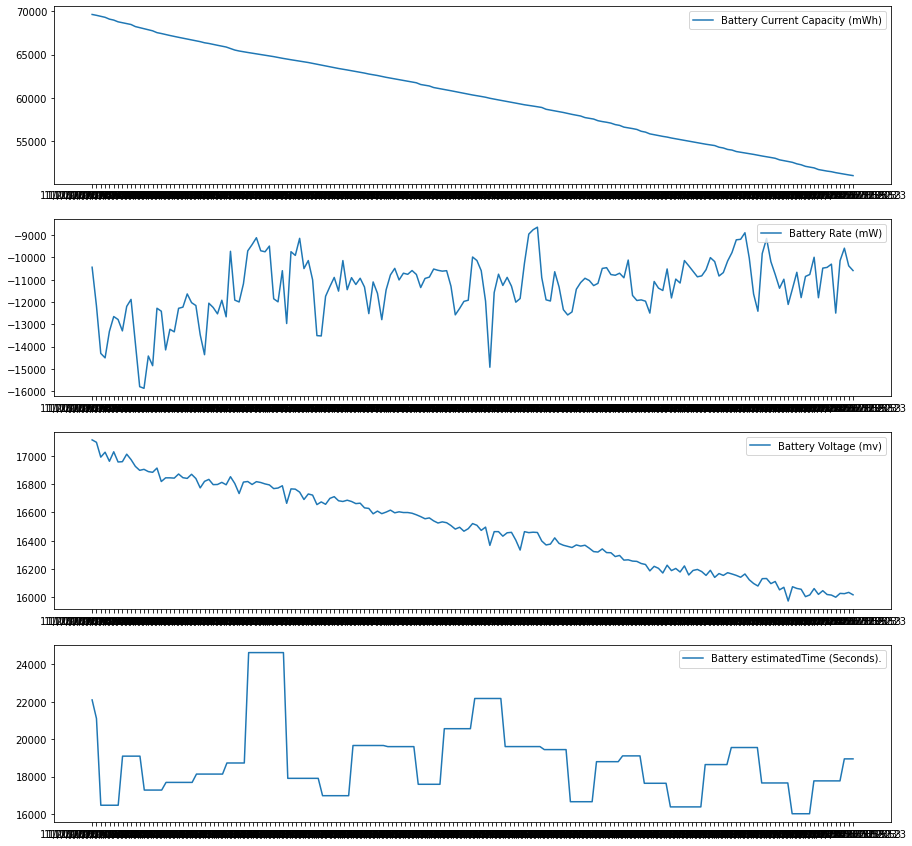

In [8]:
analysis.plot_correlation(battery5)

After detecting the trends of data, we did a correlation matrix analysis:

In [9]:
analysis.corr_matrix(battery5)

,Battery Current Capacity (mWh),Battery Rate (mW),Battery Tag,Battery Voltage (mv),Battery estimatedTime (Seconds).
Battery Current Capacity (mWh),1.000000,-0.460442,nan,0.994372,0.134995
Battery Rate (mW),-0.460442,1.000000,nan,-0.398576,0.050977
Battery Tag,nan,nan,nan,nan,nan
Battery Voltage (mv),0.994372,-0.398576,nan,1.000000,0.158022
Battery estimatedTime (Seconds).,0.134995,0.050977,nan,0.158022,1.000000
